In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

In [16]:
def get_image(image_path: str) -> np.ndarray:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (640, 480))
    image = cv2.GaussianBlur(image, (5, 5), 0)
    return image


def get_gray(image: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray


def get_skeleton(gray: np.ndarray) -> np.ndarray:
    # 转换为二值图像
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY_INV, 11, 2)
    # 二值图像的是否全空
    if cv2.countNonZero(binary) == 0:
        print('二值图像全空')

    # 细化图像，找到骨架
    skeleton = cv2.ximgproc.thinning(binary, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
    return skeleton

def skeleton_endpoints(skel: np.ndarray) -> np.ndarray:
    """
    Finds the endpoints in a skeleton image.

    Parameters:
    skel (ndarray): The input skeleton image.

    Returns:
    ndarray: An array containing the coordinates of the endpoints.
    """
    # Rest of the code...
    # Make our input nice, possibly necessary.
    skel = skel.copy()
    skel[skel!=0] = 1
    skel = np.uint8(skel)

    # Apply the convolution.
    kernel = np.uint8([[1,  1, 1],
                       [1, 10, 1],
                       [1,  1, 1]])
    src_depth = -1
    filtered = cv2.filter2D(skel,src_depth,kernel)

    # Look through to find the value of 11.
    # This returns a mask of the endpoints, but if you
    # just want the coordinates, you could simply
    # return np.where(filtered==11)
    out = np.zeros_like(skel)
    out[np.where(filtered==11)] = 1
    out = np.argwhere(out > 0)
    return out

# BFS 寻找路径函数
def bfs(skeleton: np.ndarray, start: tuple, end: tuple) -> list:
    """
    Perform breadth-first search (BFS) algorithm to find the shortest path from the start point to the end point in a skeleton.
    Parameters:
    - skeleton (numpy.ndarray): The skeleton image represented as a 2D numpy array.
    - start (tuple): The starting point coordinates (x, y) in the skeleton.
    - end (tuple): The ending point coordinates (x, y) in the skeleton.
    Returns:
    - list: The shortest path from the start point to the end point as a list of coordinates [(x1, y1), (x2, y2), ...].
           If no path is found, an empty list is returned.
    """
    # 定义 8 邻域
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    # 队列初始化，存储当前位置和路径
    queue = deque([(start, [start])])
    
    # 访问过的节点
    visited = np.zeros(skeleton.shape, dtype=np.uint8)
    visited[start] = 1
    
    while queue:
        (x, y), path = queue.popleft()
        
        # 如果找到目标端点，返回路径
        if (x, y) == end:
            return path
        
        # 遍历 8 邻域
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            # 确保新位置在图像范围内并且是骨架的一部分且未访问
            if 0 <= nx < skeleton.shape[0] and 0 <= ny < skeleton.shape[1] and skeleton[nx, ny] == 255 and not visited[nx, ny]:
                visited[nx, ny] = 1
                queue.append(((nx, ny), path + [(nx, ny)]))  # 将路径延展
    
    # 如果无法到达，返回空路径
    return []


def get_path_derivative(path: list, step: int = 10) -> dict:
    """
    Calculate the derivative of a path represented as a list of coordinates [(x1, y1), (x2, y2), ...].
    
    Parameters:
    - path (list): The input path as a list of coordinates [(x1, y1), (x2, y2), ...].
    - step (int): The step size for calculating the derivative (default: 10).
    
    Returns:
    - dict: A dictionary where the keys are points from the path and the values are the calculated derivatives.
    """
    # 提前检查路径点的数量是否足够进行拟合
    if 2 * len(path) < 3:
        raise ValueError("The path is too short for quadratic fitting (requires at least 3 points).")

    derivatives = {}
    
    for i in range(step, len(path), step):
        # 处理边界问题，确保不会超出路径范围
        start_idx = max(0, i - step)
        end_idx = min(len(path), i + step)
        
        # 提取邻近点
        x = np.array([p[0] for p in path[start_idx:end_idx]])
        y = np.array([p[1] for p in path[start_idx:end_idx]])

        # 使用二次多项式拟合
        z = np.polyfit(x, y, 2)  # z[1] 是一次项的系数，即斜率
        
        # 对拟合的多项式求导：f'(x) = 2 * z[0] * x + z[1]
        current_x = path[i][0]
        slope = 2 * z[0] * current_x + z[1]
        
        # 存储当前点的斜率
        derivatives[path[i]] = slope
        
    return derivatives
        


In [17]:
# image = get_image('../images/line.jpg')
# image = get_image('../images/bold_curve.png')
image = get_image('../images/branch.jpg')


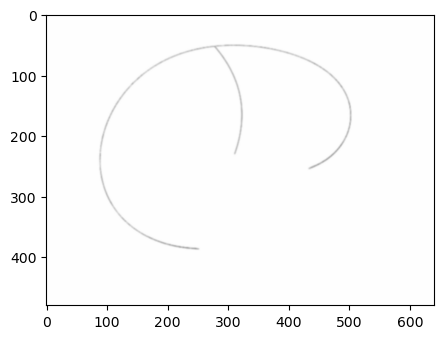

In [18]:
plt.figure(figsize=(5,5))
plt.imshow(image)
# plt.axis('off')
plt.show()


In [19]:
gray = get_gray(image)

gray = cv2.GaussianBlur(gray, (5, 5), 0)



In [20]:
skeleton = get_skeleton(gray)

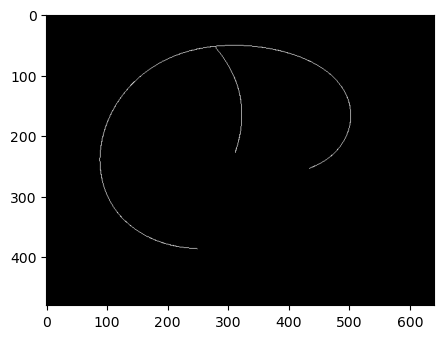

In [21]:
plt.figure(figsize=(5,5))
plt.imshow(skeleton, cmap='gray')
# plt.axis('off')
plt.show()


In [22]:
skeleton_points = np.argwhere(skeleton == 255)


In [23]:
end_points = skeleton_endpoints(skeleton)


In [24]:
# end_point = np.argwhere(end_points == 1)
print(end_points)

[[228 312]
 [254 434]
 [387 249]]


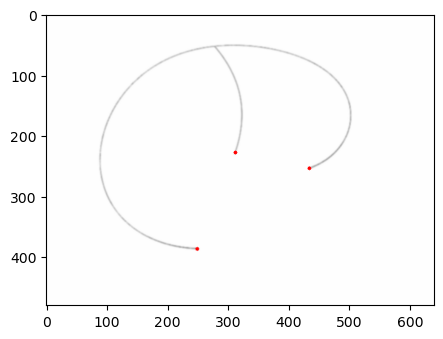

In [25]:
for point in end_points:
    cv2.circle(image, tuple(point[::-1]), 3, (255, 0, 0), -1)
    

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.show()

In [26]:
path = bfs(skeleton, tuple(end_points[0]), tuple(end_points[1]))
print(len(path))

# # 绘制路径
# for j in range(1, len(path),10):
#     cv2.circle(image, (path[j][1], path[j][0]), 1, (255, 0, 0), -1)

# plt.figure(figsize=(5,5))
# plt.imshow(image)
# plt.show()


536


In [27]:
dirivative = get_path_derivative(path, step=50)

for k, v in dirivative.items():
    print(k, v)

(178, 322) -0.0688132390670032
(128, 318) 0.2486106089600556
(78, 296) 0.3639796063101481
(51, 305) -2.4102291924013084
(54, 355) 8.99778568881706
(66, 405) 3.34300602997513
(89, 455) 1.6086097055661464
(135, 496) 0.4704947228881502
(185, 500) -0.2532258080849643
(234, 469) -1.2956392561429677


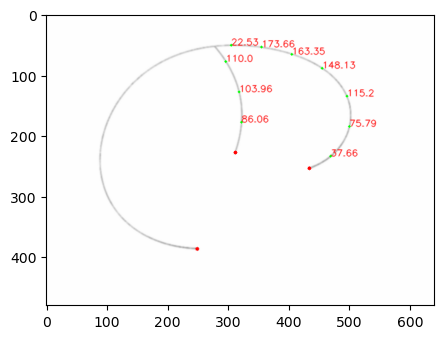

In [28]:
# plot the derivative
for point, deriv in dirivative.items():
    deriv = np.arctan(deriv)
    angle = np.degrees(deriv)
    angle += 90
    cv2.putText(image, f'{round(angle, 2)}', (point[1],point[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    cv2.circle(image, (point[1],point[0]), 2, (0, 255, 0), -1)
    
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.show()